<a href="https://colab.research.google.com/github/aaronbbarclay/mine/blob/master/Macbeth_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using mask RCNN to train macbeth detection

https://github.com/matterport/Mask_RCNN/

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python2.7/dist-packages
Requires: tensorflow-estimator, grpcio, mock, keras-applications, enum34, protobuf, keras-preprocessing, gast, tensorboard, wheel, absl-py, backports.weakref, six, numpy, termcolor, astor
Required-by: magenta, fancyimpute


In [8]:
%cd
!git clone --quiet https://github.com/tensorflow/models.git
!git clone --quiet https://github.com/matterport/Mask_RCNN/
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

/root
fatal: destination path 'models' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [17]:
%cd /root/Mask_RCNN/
%ls

/root/Mask_RCNN
assets/  LICENSE      mrcnn/     requirements.txt  setup.cfg
images/  MANIFEST.in  README.md  samples/          setup.py


In [0]:
# Install pycotools
!pip install -q pycocotools

In [10]:
# Compile protocol buffers
%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

/root/models/research


In [0]:
# Configure env variables
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/Mask_RCNN/'

import mrcnn

In [0]:
import six
import mrcnn

In [21]:
# Check environment variables
print(os.environ['PYTHONPATH'])

/env/python:/root/models/research/:/root/models/research/slim/:/root/models/research/:/root/models/research/slim/:/root/Mask_RCNN/mrcnn/:/root/models/research/:/root/models/research/slim/:/root/Mask_RCNN/:/root/models/research/:/root/models/research/slim/:/root/Mask_RCNN/


In [22]:
# Run tests
!python ~/models/research/object_detection/builders/model_builder_test.py


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.079s

OK (skipped=1)


In [48]:
# Create directories, get my repo for the images
%mkdir -p ~/data
%cd ~/data

!git clone https://github.com/aaronbbarclay/mine
%cd mine/machineLearning/macbethIdentify/data/
%ls
!unzip data.zip

/root/data
fatal: destination path 'mine' already exists and is not an empty directory.
/root/data/mine/machineLearning/macbethIdentify/data
data/  data.zip*  macbeth_identify.zip*  __MACOSX/
Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [51]:
%cd /root/data/mine/machineLearning/macbethIdentify/data/data/
%ls



/root/data/mine/machineLearning/macbethIdentify/data/data
annotations/      img/              mask_images/  train.txt*
annottions_json/  label_map.pbtxt*  test.txt*     val.txt*


In [61]:
# Setup some stuff
%cd ~/data/mine/machineLearning/macbethIdentify/data/data
%pwd
%ls
imageFilesBasePath = "/root/data/mine/machineLearning/macbethIdentify/data/data/img"
maskFilesBasePath = "/root/data/mine/machineLearning/macbethIdentify/data/data/mask_images"
annotationsFilesBasePath = '/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/data/data/annotations/'
labelMapPath = '/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/label_map.pbtxt'
testPath = '/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/test.txt'
trainPath = '/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/train.txt'
valPath = '/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/val.txt'


/root/data/mine/machineLearning/macbethIdentify/data/data
annotations/      img/              mask_images/  train.txt*
annottions_json/  label_map.pbtxt*  test.txt*     val.txt*


In [0]:
def getImageFromDir(basePath=None, filename=None, className=None):
    name, ext = filename.split(".")
    dirContents = os.listdir(basePath)
    for f in dirContents:
        maskName, maskExtension = f.split('.')
        #print("Has className: ", f, " " , className, " ", className in f)
        if f.startswith(name) and className in f:
            #print(os.path.join(basePath, f))
            return os.path.join(basePath, f)

In [0]:
def getExif(image=None, key=None):
    """
    Returns a tuple of exif key and exif value
    """
    for (k, v) in PIL.ExifTags.TAGS.items():
        if v.lower() == key:
            return (k, image._getexif()[k])
    
def fixOrientation(image=None, orientation=1):

    result = image
    print(orientation)
    if orientation == 3 : 
        result =  image.rotate(180, expand=True)
    elif orientation == 6 : 
        result = image.rotate(270, expand=True)
    elif orientation == 8 : 
        result = image.rotate(90, expand=True)
        
    return result

def isValidImage(filename=None):
    VALID_EXTENSIONS = ["jpg", "png"]
    name, extension = filename.split(".")
    
    if extension.lower() not in VALID_EXTENSIONS:
        return False
    
    return True
                        
        

IMG_1325.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/IMG_1325_class_macbeth.png
(274, 6)
6
bobby_flay_00217.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/bobby_flay_00217_class_macbeth.png
(274, 1)
1
IMG_1323.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/IMG_1323_class_macbeth.png
(274, 6)
6
megan_rapinoe_00023.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/megan_rapinoe_00023_class_macbeth.png
(274, 1)
1
IMG_1337.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/IMG_1337_class_macbeth.png
(274, 6)
6
IMG_1318.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/IMG_1318_class_macbeth.png
(274, 1)
1
IMG_1341.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask_images/IMG_1341_class_macbeth.png
(274, 6)
6
IMG_1320.jpg ---- /root/data/mine/machineLearning/macbethIdentify/data/data/mask

TypeError: ignored

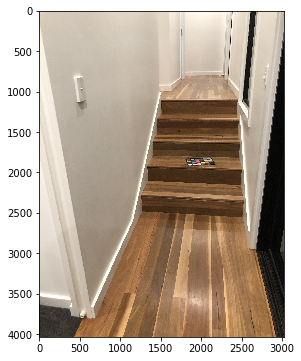

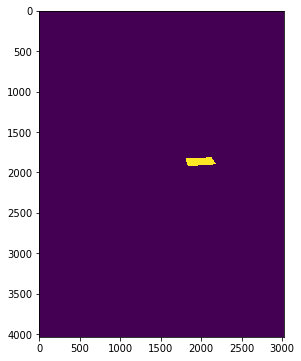

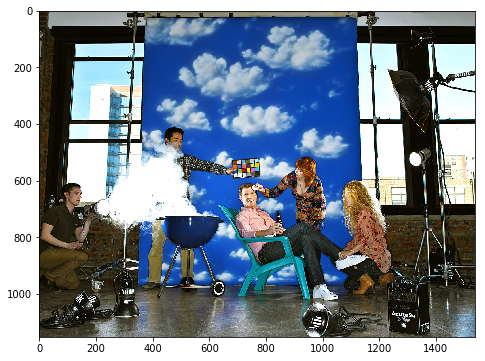

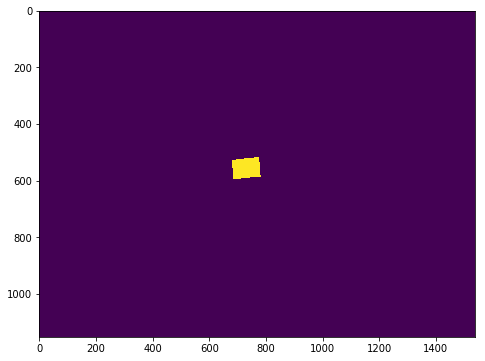

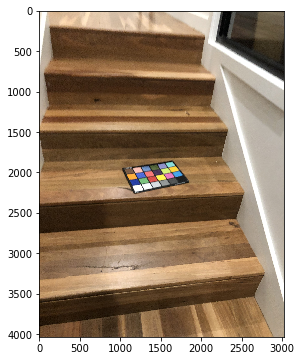

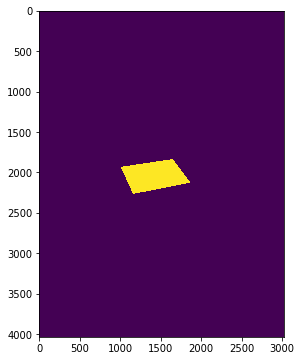

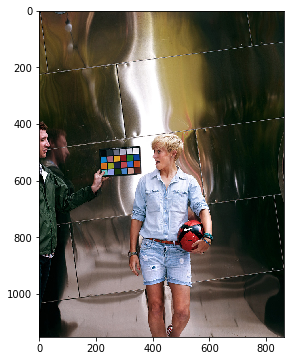

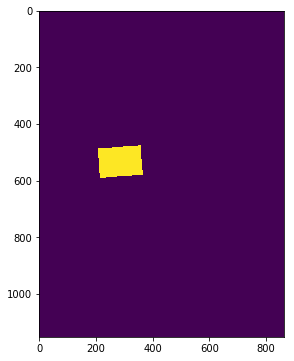

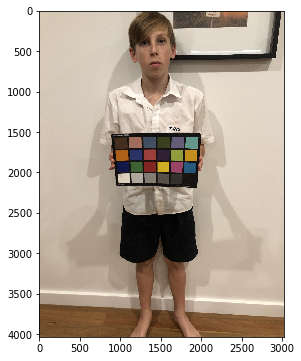

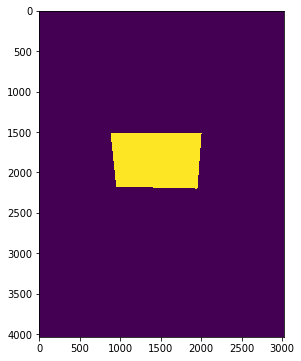

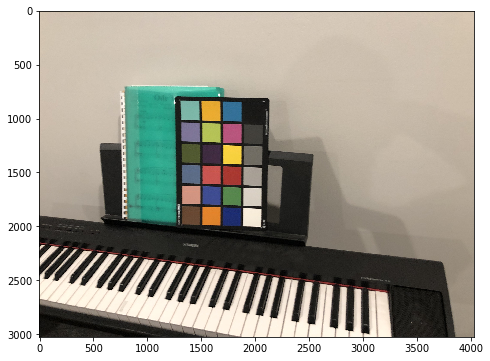

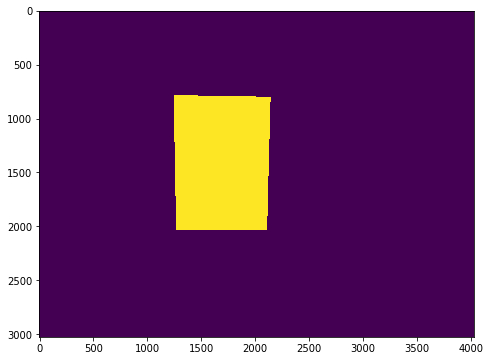

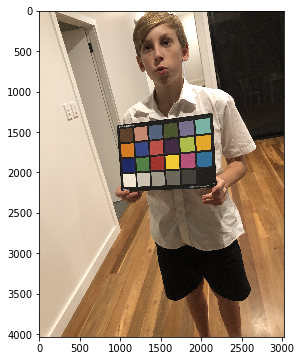

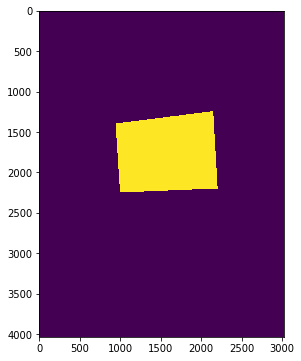

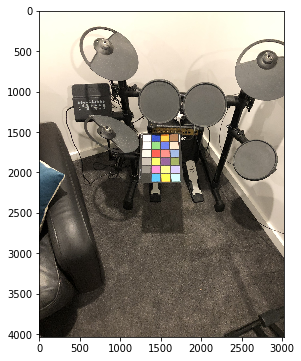

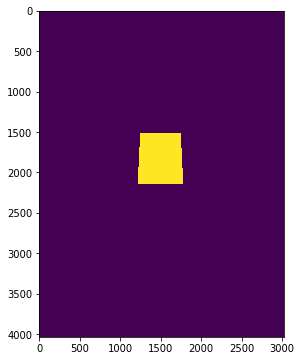

In [167]:
%matplotlib inline

from PIL import Image
import numpy
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ExifTags


for imageFilename in os.listdir(imageFilesBasePath)[:30]:
    if not isValidImage(imageFilename):
        continue
    
    imagePath = os.path.join(imageFilesBasePath, imageFilename)
    maskPath = getImageFromDir(maskFilesBasePath, imageFilename, "macbeth")

    if not maskPath:
        continue
    
    print(imageFilename, "----", maskPath)
    
    imageSrc = Image.open(imagePath)
    maskSrc = Image.open(maskPath)
    
    #print(imageSrc._getexif().items())
    #print(PIL.ExifTags.TAGS)
    #exif = dict((ExifTags.TAGS[k], v) for k, v in imageSrc._getexif() if k in ExifTage.TAGS)
    #print(exif)
    #print(imageSrc._getexif().items())
    orientation = getExif(imageSrc, "orientation")
    imageOrientated = fixOrientation(imageSrc, orientation)
    #print(PIL.ExifTags.TAGS)
    #print(PIL.ExifTags.TAGS.items())
    
    #for (k, v) in imageSrc._getexif().items():
    #    print(PIL.ExifTags.TAGS[k], v)
        
    imageArray = numpy.array(fixOrientation(imageSrc, orientation[1]))
    maskArray = numpy.array(maskSrc)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(imageArray)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(maskArray)

In [42]:
# Update and pull repo if required
%cd ~/data/mine/
%ls
!git pull


/root/data/mine
inference.ipynb  machineLearning/      README.md
Macbeth1.ipynb   mask_rcnn_demo.ipynb
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/aaronbbarclay/mine
   5cec6d5..a4cea90  master     -> origin/master
Updating 5cec6d5..a4cea90
Fast-forward
 Macbeth_learn.ipynb                           | 850 ++++++++++++++++++++++++++
 machineLearning/macbethIdentify/data/data.zip | Bin 0 -> 103237690 bytes
 2 files changed, 850 insertions(+)
 create mode 100644 Macbeth_learn.ipynb
 create mode 100755 machineLearning/macbethIdentify/data/data.zip


In [0]:
%cd /root/data/
%mkdir trimaps

from PIL import Image
image = Image.new("RGB", (640, 480))

for filename in os.listdir(annotationsFilesBasePath):
  filenameTokens = filename.split(".")
  newFileName = "trimaps/" + filename + '.png'
  print('Saving: {0}'.format(newFileName))
  image.save(newFileName)

In [0]:
# Macbeth Config

from mrcnn.config import Config

# Derived from https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb
class MacbethConfig(Config):
    # Give the configuration a recognizable name
    NAME = "macbeth"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    # Use smaller anchors because our image and objects are small
    RPM_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = MacbethConfig()
config.display()

In [0]:
%cd /root/data
%mkdir -p macbeth_learn
%ls
%cd mine/machineLearning/macbethIdentify/data/macbeth_identify/img
%ls

In [41]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn import model as modellib, utils

# Root directory of the project
ROOT_DIR = os.path.abspath("/root/data/macbeth_learn")

# URL from which to download the latest COCO trained weights
COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Dataset
class MacbethDataset(utils.Dataset):
    def load_macbeths(self, dataset_dir, subset):
        # Add classes. We have only one class to add.
        self.add_class("macbeth", 1, "macbeth")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(dataset_dir)
        
        annotations = json.load(open(os.path.join(dataset_dir, )))
        
        
        
    
    




SyntaxError: ignored

In [39]:
dataset_train = MacbethDataset()
dataset_train.load_macbeths("/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/img", "train")

/root/data/mine/machineLearning/macbethIdentify/data/macbeth_identify/img/train
